In [1]:
#Author Tanmay

import pandas as pd
from gensim import corpora, models
import gensim
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import CoherenceModel
import string
from wordcloud import WordCloud

In [2]:
# 1. Data Loading
data = pd.read_csv('foodstamp_submissions_allyears.csv')

In [17]:
# 2. Data Filtering
# Remove rows where 'selftext' is '[deleted]' or '[removed]'
filtered_data = data[~data['selftext'].str.contains('\[deleted\]', case=False, na=False)]
filtered_data = filtered_data[~filtered_data['selftext'].str.contains('\[removed\]', case=False, na=False)]

# 3. Data Preprocessing
# Handle NaN values and ensure the data type is string
filtered_data['selftext'] = filtered_data['selftext'].fillna('')
# Remove punctuation, numbers, and special characters
filtered_data['clean_selftext'] = filtered_data['selftext'].map(lambda x: re.sub('[,\.!?]', '', x))
filtered_data['clean_selftext'] = filtered_data['clean_selftext'].map(lambda x: re.sub('\d+', '', x))
# Convert to lowercase
filtered_data['clean_selftext'] = filtered_data['clean_selftext'].map(lambda x: x.lower())

In [18]:
# Remove stop words and perform lemmatization

# Add custom stopwords
stop_words = set(stopwords.words('english'))
custom_stopwords = ["i'm","im", "i've", "im", "ive","hi","etc","would","want"
,"get","Äôt","ampxb","thanks","i’m","got","th","irt","san","ca","u","cal","calfresh"
,"los","angeles","told","said","doesnt","s","k"]

stop_words = stop_words.union(custom_stopwords)

exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop_words])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

#stop = set(stopwords.words('english'))
#exclude = set(string.punctuation) 
#lemma = WordNetLemmatizer()
# def clean(doc):
#     stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
#     punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
#     normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
#     return normalized

clean_text = [clean(doc).split() for doc in filtered_data['clean_selftext']]

# Creating the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(clean_text)

# Converting list of documents (corpus) into Document Term Matrix using the dictionary prepared above
doc_term_matrix = [dictionary.doc2bow(doc) for doc in clean_text]

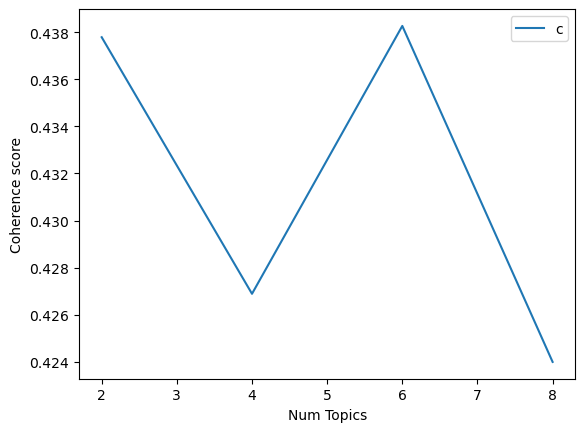

Num Topics = 2  has Coherence Value of 0.4378
Num Topics = 4  has Coherence Value of 0.4269
Num Topics = 6  has Coherence Value of 0.4383
Num Topics = 8  has Coherence Value of 0.424


In [14]:
#Deciding on what value of num_topic to choose for the most optimal results
#No Need to run this as, num_topics = 8 performed the best
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # Build LDA model
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15)
        model_list.append(model)
        
        # Compute Coherence Score using c_v
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=clean_text, start=2, limit=10, step=2)

# Show graph
import matplotlib.pyplot as plt

limit=10; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


In [19]:
# 4. LDA Modeling
# Creating the object for LDA model using gensim library & Training LDA model on the document term matrix
ldamodel = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=8, id2word = dictionary, passes=50)

In [20]:
# 5. Result Interpretation
# Print the topics and the weights of words
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.083*"card" + 0.047*"ebt" + 0.020*"balance" + 0.018*"use" + 0.011*"account" + 0.011*"anyone" + 0.009*"snap" + 0.009*"food" + 0.008*"say" + 0.008*"time"')
(1, '0.032*"food" + 0.013*"like" + 0.012*"stamp" + 0.012*"help" + 0.012*"know" + 0.008*"people" + 0.006*"need" + 0.006*"buy" + 0.006*"make" + 0.006*"even"')
(2, '0.031*"allotment" + 0.030*"emergency" + 0.025*"state" + 0.017*"benefit" + 0.016*"end" + 0.014*"anyone" + 0.012*"county" + 0.012*"month" + 0.007*"agency" + 0.007*"california"')
(3, '0.032*"month" + 0.019*"benefit" + 0.015*"job" + 0.015*"food" + 0.013*"income" + 0.011*"stamp" + 0.011*"amount" + 0.010*"pay" + 0.009*"money" + 0.009*"week"')
(4, '0.026*"child" + 0.025*"income" + 0.017*"benefit" + 0.015*"report" + 0.013*"know" + 0.011*"support" + 0.010*"school" + 0.010*"received" + 0.010*"pebt" + 0.009*"fraud"')
(5, '0.018*"call" + 0.014*"benefit" + 0.013*"day" + 0.012*"case" + 0.012*"interview" + 0.010*"received" + 0.010*"time" + 0.010*"called" + 0.010*"month" + 0.010*"back"